[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Humboldt-WI/IPML/blob/master/tutorial_notebooks/t7_classification.ipynb)

# Classification Models: The case of credit default prediction
<hr>

In [1]:
# Standard imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

## Data preparation
In this tutorial, we revisit the logistic regression model and study how it allows us to approach binary classification problems. To that end, we consider the case of credit default prediction considering the *Home Equity (HMEQ)* data set from the famous [Credit Risk Analytics](http://www.creditriskanalytics.net) textbook. It comprises information about a set of borrowers, which are categorized along demographic features and features concerning their business relationship with the lender. A binary target variable called 'BAD' is provided and indicates whether a borrower has repaid their debt. Here is an overview of the data:
- BAD: the target variable, 1=default; 0=non-default
- LOAN: amount of the loan request
- MORTDUE: amount due on an existing mortgage
- VALUE: value of current property
- REASON: DebtCon=debt consolidation; HomeImp=home improvement
- JOB: occupational categories
- YOJ: years at present job
- DEROG: number of major derogatory reports
- DELINQ: number of delinquent credit lines
- CLAGE: age of oldest credit line in months
- NINQ: number of recent credit inquiries
- CLNO: number of credit lines
- DEBTINC: debt-to-income ratio

As you can see, the features aim at describing the financial situation of a borrower, which should probably tell us something about the risk of a borrower to default.

Using the `Pandas`library, we can retrieve the data right from the web; specifically the GitHub repository of our course. 

In [2]:
url = 'https://raw.githubusercontent.com/Humboldt-WI/bads/master/data/hmeq.csv'
df = pd.read_csv(url)  # standard pandas function to load tabular data in CSV format
df.head(5)  # obtain a preview of the data by showing the first 5 rows of the table

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1100,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,1.0,9.0,NaN
1,1,1300,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833333,0.0,14.0,NaN
2,1,1500,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,1.0,10.0,NaN
3,1,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,1700,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,0.0,14.0,NaN


### Missing Values
As shown above, the data exhibits missing values. We have discussed missing values in the scope of our [EDA lecture](https://moodle.hu-berlin.de/pluginfile.php/5910736/mod_resource/content/2/ipml_s3_eda.pdf). This is not the time to revisit that material. To use the data set, we simply replace missing values using the median and mode of numerical and categorical features respectively.   

In [3]:
# Missing value handling
for col in df.columns:  # loop through all the columns (i.e., features)
    if df[col].dtype == 'O':  # decide on the imputation strategy based on the data type
        df[col].fillna(df[col].mode()[0], inplace=True)  # model replacement for categories
    else:
        df[col].fillna(df[col].median(), inplace=True)  # Mean replacement for all other features 


# Verify that the data frame does not exhibit missing values anymore
print('At this point, the data exhibits {} missing values'.format(df.isna().sum().sum()))
df.head(5)

At this point, the data exhibits 0 missing values


,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1100,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,1.0,9.0,34.818262
1,1,1300,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833333,0.0,14.0,34.818262
2,1,1500,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,1.0,10.0,34.818262
3,1,1500,65019.0,89235.5,DebtCon,Other,7.0,0.0,0.0,173.466667,1.0,20.0,34.818262
4,0,1700,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,0.0,14.0,34.818262


## Category encoding
The data set comprises two categorical variables. We must encode this before moving on. *Dummy coding* is a standard approach to do so. Dummy coding is best explained by examining how it chances our two categorical variables REASON and JOB.

In [4]:
df = pd.get_dummies(data=df, drop_first=True)
df.head(5)

,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,REASON_HomeImp,JOB_Office,JOB_Other,JOB_ProfExe,JOB_Sales,JOB_Self
0,1,1100,25860.0,39025.0,10.5,0.0,0.0,94.366667,1.0,9.0,34.818262,1,0,1,0,0,0
1,1,1300,70053.0,68400.0,7.0,0.0,2.0,121.833333,0.0,14.0,34.818262,1,0,1,0,0,0
2,1,1500,13500.0,16700.0,4.0,0.0,0.0,149.466667,1.0,10.0,34.818262,1,0,1,0,0,0
3,1,1500,65019.0,89235.5,7.0,0.0,0.0,173.466667,1.0,20.0,34.818262,0,0,1,0,0,0
4,0,1700,97800.0,112000.0,3.0,0.0,0.0,93.333333,0.0,14.0,34.818262,1,1,0,0,0,0


In [5]:
# Create our standard variables X,y for subsequent tasks
X = df.copy()
y = X.pop('BAD')

In [6]:
data_location = 'https://raw.githubusercontent.com/Humboldt-WI/bads/master/data/hmeq.csv'
df = pd.read_csv(data_location)  # standard pandas function to load tabular data in CSV format
df.head(5)  # obtain a preview of the data by showing the first 5 rows of the table

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1100,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,1.0,9.0,NaN
1,1,1300,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833333,0.0,14.0,NaN
2,1,1500,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,1.0,10.0,NaN
3,1,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,1700,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,0.0,14.0,NaN


In [7]:
data_location = 'https://raw.githubusercontent.com/stefanlessmann/ESMT_IML/master/data/hmeq.csv'
df = pd.read_csv(data_location)  # standard pandas function to load tabular data in CSV format
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5960 entries, 0 to 5959
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   BAD      5960 non-null   int64  
 1   LOAN     5960 non-null   int64  
 2   MORTDUE  5442 non-null   float64
 3   VALUE    5848 non-null   float64
 4   REASON   5708 non-null   object 
 5   JOB      5681 non-null   object 
 6   YOJ      5445 non-null   float64
 7   DEROG    5252 non-null   float64
 8   DELINQ   5380 non-null   float64
 9   CLAGE    5652 non-null   float64
 10  NINQ     5450 non-null   float64
 11  CLNO     5738 non-null   float64
 12  DEBTINC  4693 non-null   float64
dtypes: float64(9), int64(2), object(2)
memory usage: 605.4+ KB


In [8]:
# Convert a category with k different values into k-1 binary variables. 
X = pd.get_dummies(df, dummy_na=True, drop_first=True)
X = X.dropna().reset_index(drop=True)  # drop all cases with one or more missing value

# Separate the data into a matrix of feature values and a target variable
y = X.pop('BAD')

## Excercise 1: Plotting data for classification
You will remember the many plots we came across when discussing regression. We also saw some analog plots for classification problems in the [lecture](https://moodle.hu-berlin.de/pluginfile.php/5941409/mod_resource/content/1/ipml_s6_classification.pdf). One of them was a 2d scatter plot displaying the bi-variate relationship between one feature and the binary target variable. 
<br>
<img alt="Classification problem in 2D" src="https://raw.githubusercontent.com/Humboldt-WI/demopy/main/1d_classification_problem.PNG" width=600 height=800/>
<br><br>
Another was the 2d scatter plot showing two selected features and distinguishing examples of the two classes using colors.
<br>
<img alt="Classification problem in 2D" src="https://raw.githubusercontent.com/Humboldt-WI/demopy/main/2d_classification_problem.png" width=600 height=800/>
<br><br>

Your first task is to create a similar plots for the credit data. In principle, you can select any combination of features that you like.  

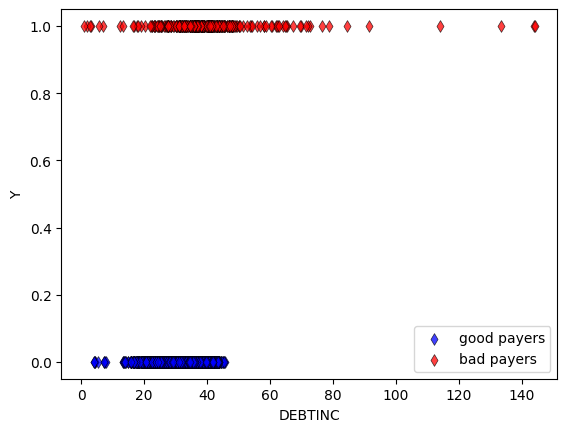

In [9]:
# Exercise 1a:
# ---
x1 = 'DEBTINC'  # select first feature of your choice

# Write code to create the scatter plot of x1 vs. y. Make sure your plot shows the data points from different classes (good and bad payers) in different colors.
plt.scatter(X[y==0][x1], y[y==0], c='blue', marker='d', label="good payers", alpha=0.75, edgecolor="black", linewidth=0.5)
plt.scatter(X[y==1][x1], y[y==1], c='red', marker='d', label="bad payers", alpha=0.75, edgecolor="black", linewidth=0.5)
plt.legend(loc='best')
plt.xlabel(x1)
plt.ylabel('Y')
plt.show()

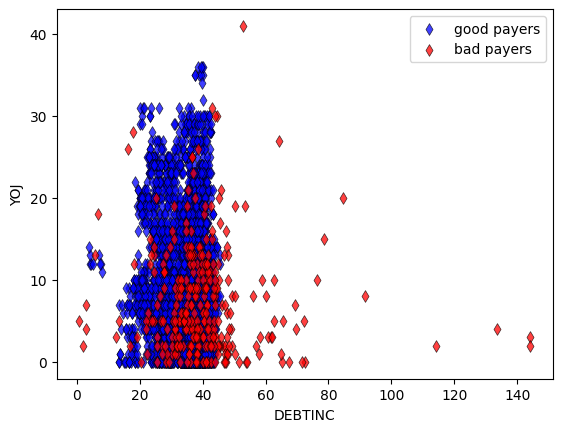

In [10]:
# Exercise 1b:
# ---
x1 = 'DEBTINC'  # select first feature of your choice
x2 = 'YOJ'  # select second feature of your choice

# Write code to create the scatter plot of x1 vs. x2. Make sure your plot shows the data points from different classes (good and bad payers) in different colors.
plt.scatter(X[y==0][x1], X[y==0][x2], c='blue', marker='d', label="good payers", alpha=0.75, edgecolor="black", linewidth=0.5)
plt.scatter(X[y==1][x1], X[y==1][x2], c='red', marker='d', label="bad payers", alpha=0.75, edgecolor="black", linewidth=0.5)
plt.legend(loc='best')
plt.xlabel(x1)
plt.ylabel(x2)
plt.show()

## Excercise 2: Model adequacy  
We introduced logistic regression as an extension of linear regression for cases in which we work with a binary target variable. Nonetheless, just as linear regression, logistic regression is a (generalized) linear model. It assumes that feature values determine the target via a linear, additive functional relationship.

Play with the above code to plot the distribution of different combinations of the features. Eventually, you should arrive at a preliminary conclusion of whether logistic regression is a suitable model for the credit risk data at hand. 

## Exercise 3: Logistic regression
Time to estimate our first model. Unsurprisingly, our goto library `sklearn` supports logistic regression through the class `LogisticRegression`, which is available in the module `sklearn.linear_models`. 

A nice feature of `sklearn`is that it facilitates using different ML algorithms through a common interface. This means that the way in which you use, for example train and test, a model is basically the same no matter which learning algorithm you use. Last week, we examined the implementation of linear regression. So, the way to use logistic regression should be very similar. Feel free to draw on the examples from last week and/or the corresponding [solution notebook](https://github.com/Humboldt-WI/IPML/blob/main/tutorial_notebooks/t6_regression_solution.ipynb). You task is to:
- partition our data into a 75% training and 25% test set,
- train a logistic regression model on the training set,
- and compute predictions for the test set. 

### Model training

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Partition the data
Xtr, Xts, ytr, yts = train_test_split(X, y, test_size=0.25)

lr_model = LogisticRegression(random_state=888).fit(Xtr, ytr)  # we define a random_state to ensure that we get the same results when re-running this cell multiple times
lr_model

LogisticRegression(random_state=888)

Note that the `sklearn` implementation does not provide an informative summary, as did the library `statsmodels`, which you saw in our [regression notebook](https://github.com/Humboldt-WI/IPML/blob/main/tutorial_notebooks/t6_regression_solution.ipynb). Basically, the reason is that `sklearn` is designed to support prediction. Let's demonstrate how to do this, that is compute predictions using the trained model.

### Test set predictions

In [12]:
yhat = lr_model.predict(Xts)  # simply way to compute predictions using logistic regression and any other machine learning model in sklearn 

Likely, you are also interested to assess the model. There is an easy way to do this:

In [13]:
perf = lr_model.score(Xts, yts)  # Call a general purpose evaluation function and obtain a (quality ) score of the model
print('Logit model achieves a score of {:.3f} %'.format(perf*100))

Logit model achieves a score of 91.354 %


## Exercise 4: Diagnosing predictions

### 4a) Classification accuracy and the score function
Likely, you are also interested in assessing the model. There is an easy way to do this. Just call the function `score()`, which the trained logistic regression model supports. More specifically, assume the variable that you created above is called `lr_model`, and assume further that your feature matrix and target variable are called `X` and `y`, respectively. Then, you can run:
```
lr_model.score(X,y)
```
Try it out but remember to adjust the names of the variables appropriately. 

In [14]:
# Compute the score of the logistic regression model
lr_model.score(Xts, yts)

0.9135381114903299

Supposedly, you will have observed a score of about 80 percent, which does sound pretty good, right? Well, to be sure we should better understand for start what this number means, that is, what *score* we have just calculated. It turns out that when you call the `score()` function for a classification model, you receive an estimate of that model's classification accuracy as result. Regression models would produce a different *score*. To verify your score is indeed the classification accuracy, recalculate classification *manually*. In case, recall how we defined classification accuracy in the lecture:

<br>
<img alt="Classification problem in 2D" src="https://raw.githubusercontent.com/Humboldt-WI/demopy/main/confusion_matrix.PNG" width=600 height=800/>
<br><br>

In [15]:
# Code to compute (test set) accuracy
pcc = np.sum((yhat==yts).astype(np.int16)) / len(yts)
print('Manually calculated accuracy equals {:.4f}'.format(pcc))

Manually calculated accuracy equals 0.9135


### 4b) Comparing to a naive classifier
Interpreting classification accuracy, and more generally the performance of any predictive model, it is useful to compare is to a baseline. But what baseline? We face a classification problem. There are two classes, good payers and bad payers, and we aim to tell these apart. Come up with a very basic - naive - strategy to solve the classification problem without using any model. Write a piece of code to calculate the classification accuracy of your naive strategy and compare to logistic regression. 
> Hint: if you feel a bit lost, consider web searching for *dummy classifier* 

In [16]:
# Code to calculate the score of a naive classifier or dummy classifier
from sklearn.dummy import DummyClassifier  # instead of using sklearn, you could also compute the naive classifier's accuracy manually

dc = DummyClassifier().fit(Xtr, ytr)
dc.score(Xts, yts)

0.9135381114903299

### 4c) Confusion matrix
The comparison of logistic regression to a naive classifier should have revealed that your model is not that strong after all. Classification accuracy of almost 80% sounds good at first glance but is far less impressive when knowing that naively predicting the majority class gives basically the same result. To get a better understanding of how well (or poorly) the model classifiers, your next task is to produce a confusion matrix. You can find all the functionality that you need in the class `ConfusionMatrixDisplay`, which is part of the `sklearn.metrics` module. So, import that class, examine how it works using the documentation, and plot a beautiful confusion matrix for your logistic regression model. Once you acomplished this task, make sure to study the result and discuss the quality of the classifier.

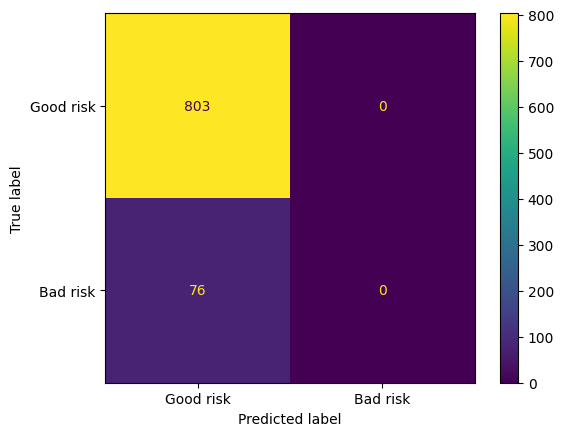

In [17]:
from sklearn.metrics import ConfusionMatrixDisplay 
ConfusionMatrixDisplay.from_predictions(yts,    # of course we use the test set
                                        yhat,  # here, we assume you solved exercise 4 and created an array of discrete class predictions
                                        display_labels=['Good risk', 'Bad risk'])  # more readable labels for labeling the axes of our matrix
plt.show()

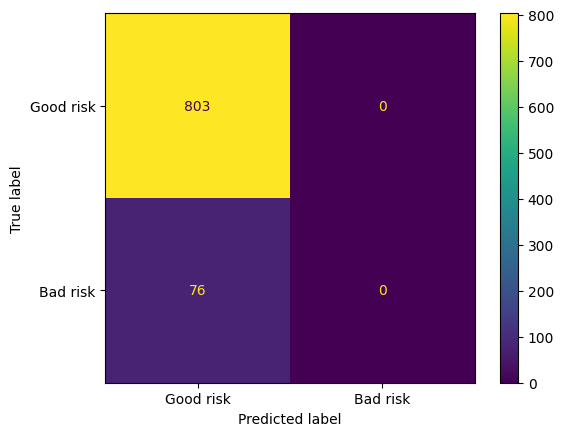

In [18]:
# The class also supports an alternative way to construct the matrix from the trained classifier
from sklearn.metrics import ConfusionMatrixDisplay 
ConfusionMatrixDisplay.from_estimator(lr_model,    
                                      Xts,  # of course we use the test set
                                      yts,  # here, we assume you solved exercise 4 and created an array of discrete class predictions
                                      display_labels=['Good risk', 'Bad risk'])  # more readable labels for labeling the axes of our matrix
plt.show()

The result is certainly the same but note how the second option is more convenient if you have not yet created predictions. Last, if you are only interested in the numbers the easiest way to get these is:

In [19]:
from sklearn.metrics import confusion_matrix
confusion_matrix(yts, yhat)

array([[803,   0],
       [ 76,   0]])

## Exercise 5: ROC Analysis
Previous analysis suggests that the logistic regression model was not doing a good job. It barely recognizes the bad risks, which is the key objective of a credit default prediction model. That said, don't be too quick with dismissing the model. Recall that the confusion matrix is based on a cut-off value:

<br>
<img alt="Classification problem in 2D" src="https://raw.githubusercontent.com/Humboldt-WI/demopy/main/classification_cutoff.PNG" width=600 height=800/>
<br><br>

Up to this point, we did not set the cut-off value anywhere. Given this, it is actually surprising that we have been able to create a confusion matrix in the previous exercise. The reason for this is that `sklearn` assumes a default cut-off value of 0.5. This cut-off is used whenever you call the function `predict()` for a classifier. In our opinion, this makes the `predict()` function rather useless for classification. For classification problems, you should routinely compute probability predictions. If you seek discrete class predictions, compare the model-based probability predictions to a cut-off; as illustrated in the above picture. How to choose a **suitable** cut-off is a nontrivial question and out-of-the-scope of this notebook. Rather, as the title of the exercise has already indicated, we want to revisit ROC analysis. To that end, produce probability forecasts for the test data set using your logistic regression model.

### 5a) Probability predictions
Compute probabilistic predictions using the function `predict_proba()`. Create a variable `yhat_prob` to store the results.

In [20]:
yhat_prob = lr_model.predict_proba(Xts)
yhat_prob

array([[0.88220389, 0.11779611],
       [0.87108336, 0.12891664],
       [0.89693648, 0.10306352],
       ...,
       [0.93558986, 0.06441014],
       [0.98528048, 0.01471952],
       [0.79081096, 0.20918904]])

Note how predict_proba returns the probabilities of both classes. This appears awkward. Given they add up to one, why have both? The answer is that `sklearn` aims to be consistent. Whenever you face a multi-class problem, it is essential to return the estimated probabilities of each class. Thus, for the sake of consistency, the implementation of the `predict_proba()` function is such that it returns probability estimates for each class.

### 5b) ROC curve
The probabilistic predictions are the foundation of the ROC curve. Roughly speaking, we compare them to all possible cut-off values, derive all possible confusion matrices, extract the true positive rate and false positive rates from these confusion matrixes, and plot those values against one another. Of course, we do not have to do this by hand. Instead, sklearn provides the corresponding functionality via several functions and classes including `roc_curve`, `RocCurveDisplay()`, and, if you only care about the AUC score, `roc_auc_score`. All of them are available in the module `sklearn.metrics`. Your task is to import these functions and familiarize yourself with the functionality. Begin with the class `RocCurveDisplay()`, which should quickly produce you a nice ROC curve. Afterward, try to augment your curve using the diagonal line. A discussed in the lecture, a diagonal line in ROC space represents the performance of guessing classes at random. Next, we create the plot using the function `roc_curve`, which offers more flexibility but also requires you to write more code. 

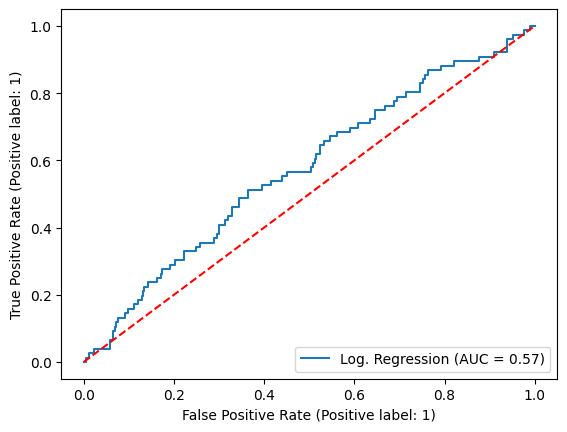

In [21]:
from sklearn.metrics import RocCurveDisplay, roc_curve, roc_auc_score
RocCurveDisplay.from_predictions(yts,  # true repayment behavior for test set observations
                                 yhat_prob[:,1],  # probability predictions of the logistic regression model, whereby we only use those of class 1 (see above)
                                 name='Log. Regression',  # just formatting the legend of the plot
                                 pos_label=1)
plt.plot([0, 1], [0, 1], "r--")  # adding in the random benchmark, 
plt.show()


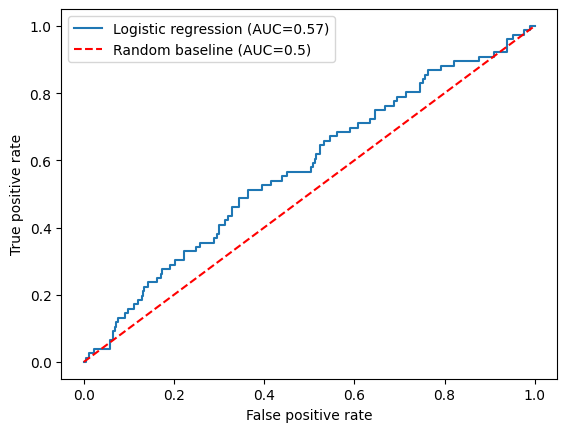

In [22]:
# Excerting more control using roc_curve
fpr, tpr, cut_offs = roc_curve(yts, yhat_prob[:,1], pos_label=1)
plt.plot(fpr, tpr, label='Logistic regression (AUC={:.2f})'.format(roc_auc_score(yts, yhat_prob[:,1])))
plt.plot([0, 1], [0, 1], 'r--', label='Random baseline (AUC=0.5)')  # adding in the random benchmark 
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc='best')
plt.show()

### 5c) K-fold cross-validation

$K$-Fold Cross-Validation allows us to evaluate a model's performance and generalization capability. The process involves dividing the dataset into $K$ subsets or "folds". The model is then trained on $K-1$ folds and tested on the remaining one, repeating this process $K$ times. The resulting $K$ performance scores provide a robust assessment of the model's overall capability, making it an essential practice when developing machine learning models using Python and similar languages. We will use $K$-fold cross-validation to get a robust estimate of the AUC ROC.

In [56]:
from sklearn.model_selection import KFold

auc_roc_scores = []

for i, (train_index, test_index) in enumerate(KFold(n_splits=7).split(X)):
    print(f'\nFold {i+1}:')
    lr_model = LogisticRegression(max_iter=1000).fit(X.iloc[train_index], y.iloc[train_index].values)
    y_pred = lr_model.predict_proba(X.iloc[test_index])[:,1]
    auc_roc = roc_auc_score(y.iloc[test_index].values, y_pred)
    auc_roc_scores.append(auc_roc)
    print(f'   AUC ROC: {auc_roc}')
    
print(f'\n\nAverage AUC ROC: {np.mean(auc_roc_scores)}')


Fold 1:
   AUC ROC: 0.6979405034324943

Fold 2:
   AUC ROC: 0.7494046630115744

Fold 3:
   AUC ROC: 0.6894283121597096

Fold 4:
   AUC ROC: 0.6512155950600875

Fold 5:
   AUC ROC: 0.6344071996869701

Fold 6:
   AUC ROC: 0.5579687977974916

Fold 7:
   AUC ROC: 0.5552087191153907


Average AUC ROC: 0.6479391128948169


## The visual logistic regression
We complete this part with a visual demo of the logistic regression model. No more work for you, just execute the code and enjoy. And of discuss the plot to make sure you understand how it depicts the classification solution of our logistic regression model. 

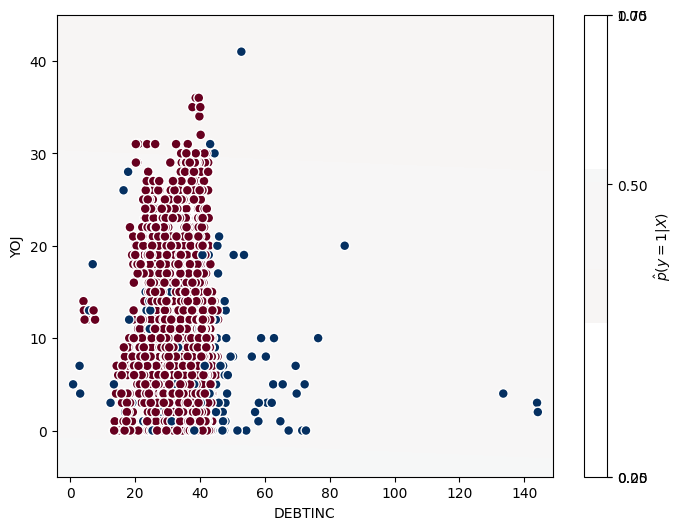

In [23]:
def plot_logit_decision_surface(model, y, data, x1, x2, save_fig=False):
    '''
        Visualization of logistic regression in 2D
        
        Creates a plot depicting the distribution of the input
        data along two dimensions and the probability predictions
        of a logistic regression model. 

        Parameters
        ----------
        model :   An instance of the sklearn class LogisticRegression,  which        
                  has been trained on the input data.

        y     :   The true outcomes of the target variable 
        
        data  :   Pandas data frame providing the feature values.

        x1, x2:   The function plots the results of logistic regression in
                  two dimensions. The parameters x1 and x2 give the names
                  of the features used for plotting. These features will be
                  extracted from the data frame.

        save_fig: Binary variable allowing you to save the figure as a PNG image. 
                  Default: False

        Returns
        ----------
        The function does not return a result. It's purpose is to visualize 
        logistic regression model. The corresponding plot is the only output.
    '''

    #if len(model.coef_.ravel())!=2:
    #    raise Exception('Please estimate a logit model using only two features!')
    # Define some variables to govern the plot
    bounds = data.describe().loc[["min", "max"]][[x1, x2]].to_numpy()  # value ranges of the two features
    eps = 5  # tolerance parameter 

    # Create hypothetical data points spanning the entire range of feature values.
    # We need these to get from our logistic regression model a probability prediction
    # for every possible data point
    xx, yy = np.mgrid[(bounds[0,0]-eps):(bounds[1,0]+eps), (bounds[0,1]-eps):(bounds[1,1]+eps)]
    grid = np.c_[xx.ravel(), yy.ravel()]

    # Perhaps the logistic regression model was fitted using the full data frame. 
    # To also work in that case, we extract the estimated regression coefficients 
    # corresponding to the two features we consider for plotting
    feature_to_index = {name: idx for idx, name in enumerate(model.feature_names_in_)}  # create a dic as intermediate step
    indices = [feature_to_index[f] for f in [x1, x2]]  # Find the indices of our two features of interest using the dic
    w = model.coef_.ravel()[indices]  # estimated regression coefficients
    b = model.intercept_  # estimated intercept of the logistic regression model

    # Compute probability predictions over the entire space of possible feature values
    # In the interest of robustness, we manually compute the logistic regression predictions
    # using the regression coefficients extracted above
    probs = 1/(1+np.exp(-(np.dot(grid, w.reshape(2,-1))+b))).reshape(xx.shape)

    # We are finally ready to create our visualization
    f, ax = plt.subplots(figsize=(8, 6))  # new figure
    # Contour plot of the probability predictions across the entire feature range
    contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu", vmin=0, vmax=1)  
    ax_c = f.colorbar(contour)
    ax_c.set_label("$\hat{p}(y=1|X)$")
    ax_c.set_ticks([0, .25, .5, .75, 1])

    # Scatter plot of the actual data
    ax.scatter(data[x1], data[x2], c=y, s=50, cmap="RdBu", vmin=0, vmax=1,
               edgecolor="white", linewidth=1);
    plt.xlabel(x1)
    plt.ylabel(x2)
    if save_fig==True:
        plt.savefig('logit_contour.png')
    plt.show()


# Calling the function
plot_logit_decision_surface(lr_model, ytr, Xtr, 'DEBTINC', 'YOJ')

# Well done! This was another comprehensive set of exercises.